<a href="https://colab.research.google.com/github/leeyejin1231/Machine_Learning_study/blob/main/IMDBMovieReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IMDB리뷰 감성 분석하기
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import imdb

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


In [3]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


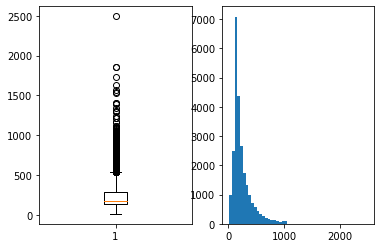

In [4]:
len_result = [len(s) for s in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [5]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


In [6]:
word_to_index = imdb.get_word_index()
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

1654784/1641221 [==============================] - 0s 0us/step


In [7]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))

빈도수 상위 1등 단어 : the


In [8]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

In [9]:
#IMDB로 감성 분류하기
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [10]:
vocab_size = 10000   #집합크기 10,000으로 제한
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

In [11]:
max_len = 500   #리뷰길이 500으로 제한
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=2, callbacks=[es, mc], batch_size=60, validation_split=0.2)
# 엄청 오래걸림!!!!

Epoch 1/2
334/334 [==============================] - ETA: 0s - loss: 0.5007 - acc: 0.7621
Epoch 00001: val_acc improved from -inf to 0.85820, saving model to GRU_model.h5
334/334 [==============================] - 36s 91ms/step - loss: 0.5007 - acc: 0.7621 - val_loss: 0.3477 - val_acc: 0.8582
Epoch 2/2
334/334 [==============================] - ETA: 0s - loss: 0.3149 - acc: 0.8741
Epoch 00002: val_acc improved from 0.85820 to 0.87440, saving model to GRU_model.h5
334/334 [==============================] - 29s 88ms/step - loss: 0.3149 - acc: 0.8741 - val_loss: 0.3192 - val_acc: 0.8744


In [15]:
loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 26s 33ms/step - loss: 0.3321 - acc: 0.8654

 테스트 정확도: 0.8654


In [16]:
def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

  # 정수 인코딩
  encoded = []
  for word in new_sentence.split():
    # 단어 집합의 크기를 10,000으로 제한.
    try :
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
    # 10,000 이상의 숫자는 <unk> 토큰으로 취급.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 취급.
    except KeyError:
      encoded.append(2)

  pad_new = pad_sequences([encoded], maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [19]:
temp_str = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(temp_str)

70.95% 확률로 부정 리뷰입니다.


In [20]:
temp_str = "I love this movie. I want to see that again!"

sentiment_predict(temp_str)

93.25% 확률로 긍정 리뷰입니다.


In [21]:
temp_str = "not bad."

sentiment_predict(temp_str)

51.03% 확률로 긍정 리뷰입니다.


##....음...? good들어간다고 다 긍정이니..?

In [22]:
temp_str = "not good."

sentiment_predict(temp_str)

94.05% 확률로 긍정 리뷰입니다.
